#Построение классификатора и регрессора для дата-сета по покемонам.

In [2]:
"""
https://www.kaggle.com/rounakbanik/pokemon

Постройте классификатор, отвечающий на вопрос 'является ли покемон легендарным?'.

Наберите команду из N покемонов, максимизирующую причиняемый урон.

Евгений Раскин, 192 группа
"""
import pandas
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import learning_curve

После импорта всех модулей, построим классификатор, определяющий легендарных покемонов. Для этого используем алгоритм "Наивный Байес".

In [3]:
# Load our data
data = pandas.read_csv("pokemon.csv")

# Organize our data
X = data.drop(columns=["is_legendary"])
y = data["is_legendary"]

# Split our data to test and train samples
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, 
                                                    random_state=42)

# Handle features
integer_values = X.select_dtypes(include=['integer']).columns.to_list()

# Initialize our classifier
gnb = GaussianNB()

# Train
model = gnb.fit(X_train[integer_values], y_train)

# Predict
predictions = model.predict(X_test[integer_values])

# Evaluate accuracy
print(accuracy_score(y_test, predictions))

0.9626556016597511


Выше был подсчитана точность нашей модели. Структура данных видна ниже.

In [4]:
data.head(5)

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water,attack,base_egg_steps,base_happiness,base_total,capture_rate,classfication,defense,experience_growth,height_m,hp,japanese_name,name,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,49,5120,70,318,45,Seed Pokémon,49,1059860,0.7,45,Fushigidaneフシギダネ,Bulbasaur,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,62,5120,70,405,45,Seed Pokémon,63,1059860,1.0,60,Fushigisouフシギソウ,Ivysaur,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,100,5120,70,625,45,Seed Pokémon,123,1059860,2.0,80,Fushigibanaフシギバナ,Venusaur,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,52,5120,70,309,45,Lizard Pokémon,43,1059860,0.6,39,Hitokageヒトカゲ,Charmander,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,64,5120,70,405,45,Flame Pokémon,58,1059860,1.1,58,Lizardoリザード,Charmeleon,88.1,5,80,65,80,fire,NaN,19.0,1,0


Построим матрицу неточности, кривую обучения и кривую ROC для оценки классификатора.

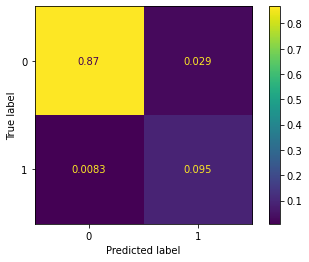

In [5]:
plot_confusion_matrix(gnb, X_test[integer_values], y_test, normalize='all')
plt.show()

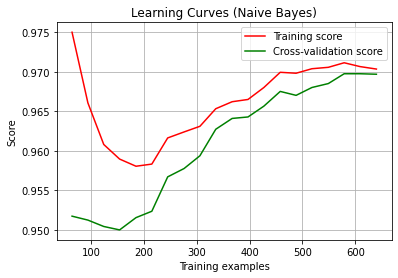

In [6]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

train_sizes, train_scores, test_scores = learning_curve(gnb, X[integer_values], y, n_jobs=4, cv=cv,
                                                        train_sizes=np.linspace(0.1, 1.0, 20))
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, color="g", label="Cross-validation score")
plt.grid()
plt.legend()
plt.title("Learning Curves (Naive Bayes)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.show()

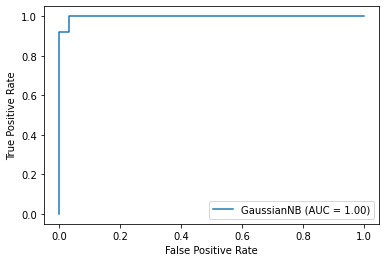

In [7]:
plot_roc_curve(gnb, X_test[integer_values], y_test)
plt.show()

Построим теперь линейный регрессор, который будет определять значение атаки для отдельного покемона в зависимости от его характеристик.

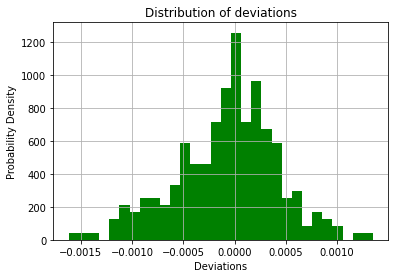

In [8]:
from sklearn import linear_model
import scipy.stats
import numpy as np
sp_attacks = data["sp_attack"]
X = data.drop(columns=["sp_attack"])
y = data["sp_attack"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, 
                                                    random_state=42)
integer_values = X.select_dtypes(include=['integer']).columns.to_list()

regression = linear_model.Ridge()
model = regression.fit(X_train[integer_values], y_train)

# Predict
predictions = regression.predict(X_test[integer_values])

deviations = []
for dummy_i in enumerate(X_test["sp_defense"].keys()):
    deviations.append((predictions[dummy_i[0]] - sp_attacks[dummy_i[1]]))
deviations = sorted(deviations)
# Visualize 
plt.hist(deviations, bins=30, density=True, color='green')
plt.title("Distribution of deviations")
plt.xlabel("Deviations")
plt.ylabel("Probability Density")
plt.grid()
plt.show()

Выше представлено распределение отклонений оценки нашей модели от истинных значений. Построим также кривую обучения для полученного линейного регрессора. 

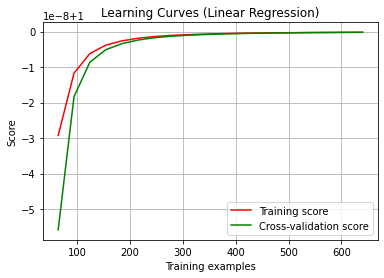

In [9]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

train_sizes, train_scores, test_scores = learning_curve(regression, X[integer_values], y, n_jobs=4, cv=cv,
                                                        train_sizes=np.linspace(0.1, 1.0, 20))
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, color="g", label="Cross-validation score")
plt.grid()
plt.legend()
plt.title("Learning Curves (Linear Regression)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.show()

Вычислим метрики для оценки точности линейного регрессора.

In [10]:
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))  
print('Mean Squared Error:', mean_squared_error(y_test, predictions))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))

Mean Absolute Error: 0.00038075777321997526
Mean Squared Error: 2.520526291717532e-07
Root Mean Squared Error: 0.0005020484330936142


In [13]:
predictions_total = regression.predict(data[integer_values])